In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

%run backwards_time_voter_model.ipynb

In [12]:
# Define parameters as in paper
alpha = 3e-3
eta = -7.2
widths = [4, 16, 32]
L = 300

## Load in saved grids for different etas or different kernel widths and compute grid

In [13]:
grids = []
species_sizes = []

for W in widths:
    for i in range(10, 13):
        species_load = pickle.load(open(f"Varying width runs/{L}x{L},alpha={alpha},kernel=fat_tail,eta={eta},W={W}.p_{i}", "rb" ))
        for specie in species_load:
            species_sizes.append(len(specie))
        species_ids = np.random.uniform(size=len(species_load))

        grid = np.zeros((L, L))
        for i, specie in enumerate(species_load):
            for coord in specie:
                grid[coord] = species_ids[i]
        grids.append(grid)

## Visualize simulated ecosystems as 2D grids

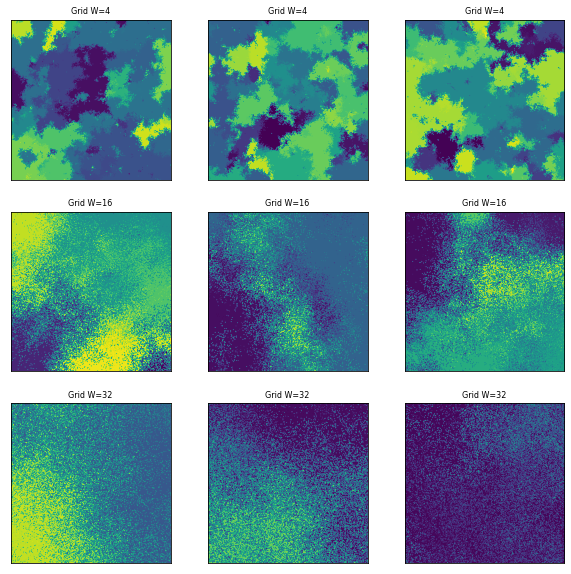

In [14]:
mpl.rc('font', size=8)

fig, axs = plt.subplots(3, 3, figsize = (10,10))

counter = 0

# Plot ecosystems for all widths
for r in range(3):
    for c in range(3):
        axs[r,c].imshow(grids[counter])
        axs[r,c].set_title(f'Grid W={widths[r]}', fontsize = 8)
        axs[r,c].set_xticks([])
        axs[r,c].set_yticks([])
        counter += 1
        
plt.show()

## Average grids over multiple runs

In [15]:
avg_grids = []

for i in range(3):
    g = (grids[0+i] + grids[1+i] + grids[2+i]) / 3.0
    avg_grids.append(g)

## Plot mean Species-Area curves

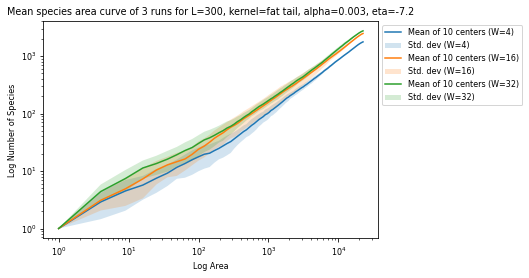

In [16]:
centers = 10

for i, grid in enumerate(avg_grids):
        areas, num_species = sa_curve(grid,centers)
        spec_std_dev = np.std(num_species, axis=0)
        spec_mean = np.mean(num_species, axis=0)
      
        plt.loglog(areas, list(spec_mean), label=f'Mean of {centers} centers (W={widths[i]})')
        plt.fill_between(areas, spec_mean-spec_std_dev, spec_mean+spec_std_dev, alpha=0.2, label=f'Std. dev (W={widths[i]})')

plt.ylabel('Log Number of Species')
plt.xlabel('Log Area')
plt.title(f'Mean species area curve of 3 runs for L={L}, kernel=fat tail, alpha={alpha}, eta={eta}')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Show that fitted curve is a good fit to data

In [17]:
def power_law(A, c, z):
    '''Calculate power law distribution'''
    return c*A**z

In [18]:
from scipy.stats import kstest
from scipy.optimize import curve_fit

start = 25
(fit_c, fit_z), pcov = curve_fit(power_law, areas[start:], spec_mean[start:], p0=[0.1, 1])
res = kstest(spec_mean[start:], fit_c*np.array(areas[start:])**fit_z)
print(res)

KstestResult(statistic=0.024, pvalue=0.9999999999999969)


## Fit a curve on global scale of Species-Area curve

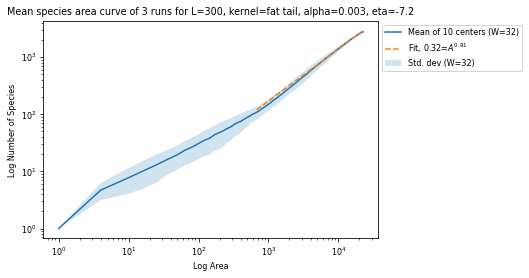

In [19]:
from scipy.stats import kstest
from scipy.optimize import curve_fit

start = 25
centers = 10


areas, num_species = sa_curve(avg_grids[2],centers)
spec_std_dev = np.std(num_species, axis=0)
spec_mean = np.mean(num_species, axis=0)

(fit_c, fit_z), pcov = curve_fit(power_law, areas[start:], spec_mean[start:], p0=[0.1, 1])       

plt.loglog(areas, list(spec_mean), label=f'Mean of {centers} centers (W={widths[2]})')

plt.loglog([areas[start], areas[-1]],
           fit_c*np.array([areas[start], areas[-1]])**fit_z,
           linestyle='dashed',
           color='C1',
           label=rf'Fit, {round(fit_c, 2)}=$A^{{{round(fit_z, 2)}}}$')

plt.fill_between(areas, spec_mean-spec_std_dev, spec_mean+spec_std_dev, alpha=0.2, label=f'Std. dev (W={widths[2]})')

plt.ylabel('Log Number of Species')
plt.xlabel('Log Area')
plt.title(f'Mean species area curve of 3 runs for L={L}, kernel=fat tail, alpha={alpha}, eta={eta}')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Plot fat tail distribution using kernel function

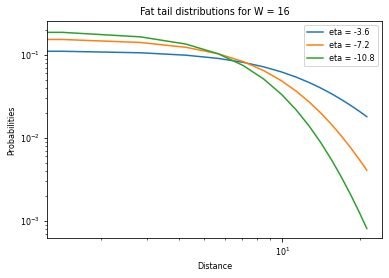

In [21]:
from sklearn.metrics.pairwise import euclidean_distances


etas = [-3.6,-7.2,-10.8]
W = 16

for eta in etas:
    probabilities = []
    neighbors = []

    for i in range(W):
        neighbors.append((i,i))

    dist = euclidean_distances([[0,0]],neighbors)
    dist = dist[0]

    for d in dist:
        K = -((eta + 2) / (2 * np.pi * W**2)) * (1 + ((d)/W)**2 )**(eta/2)
        probabilities.append(K)
    probabilities = np.array(probabilities)/sum(probabilities)

    plt.loglog(dist,probabilities,label=f'eta = {eta}')

plt.legend()
plt.xlabel('Distance')
plt.ylabel('Probabilities')
plt.title(f'Fat tail distributions for W = {W}')
plt.show()